In [10]:
%pylab --no-import-all inline

Populating the interactive namespace from numpy and matplotlib


# Clustering analysis

Use various clustering techniques to identify a good subset of questions.

---

In [28]:
import os
import sys

import pandas as pd
import seaborn as sns

# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.pardir, 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport visualization.visualize
from visualization.visualize import biplot, plot_explained_variance, triplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
df = pd.read_csv("../data/processed/2012.csv", index_col=0)

---

## Correlations in data

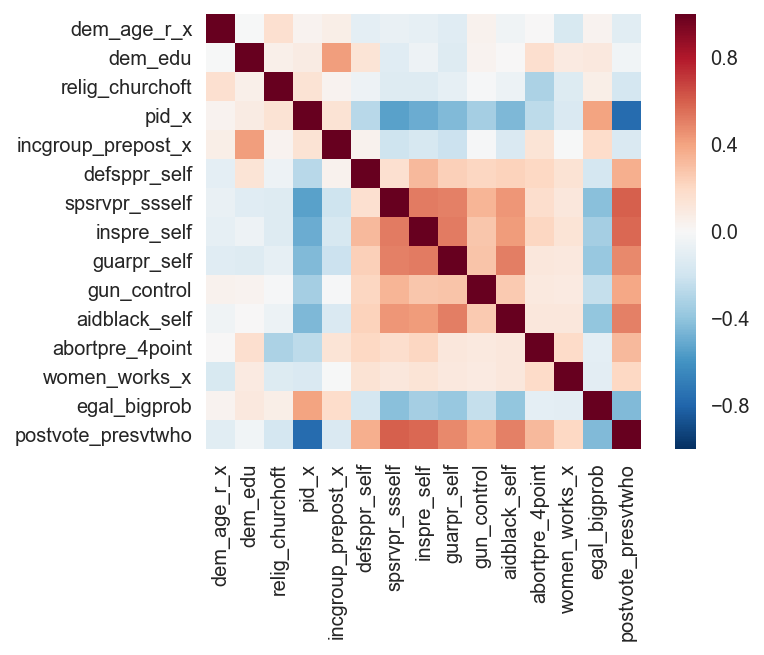

In [13]:
# Spearman is recommended for ordinal data.
correlations = df.corr(method='spearman')
sns.heatmap(correlations, square=True);

Note that if we were to scale the data, the correlation matrix would be unchanged.

/Users/Arya/anaconda/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning:

The axisbg attribute was deprecated in version 2.0. Use facecolor instead.



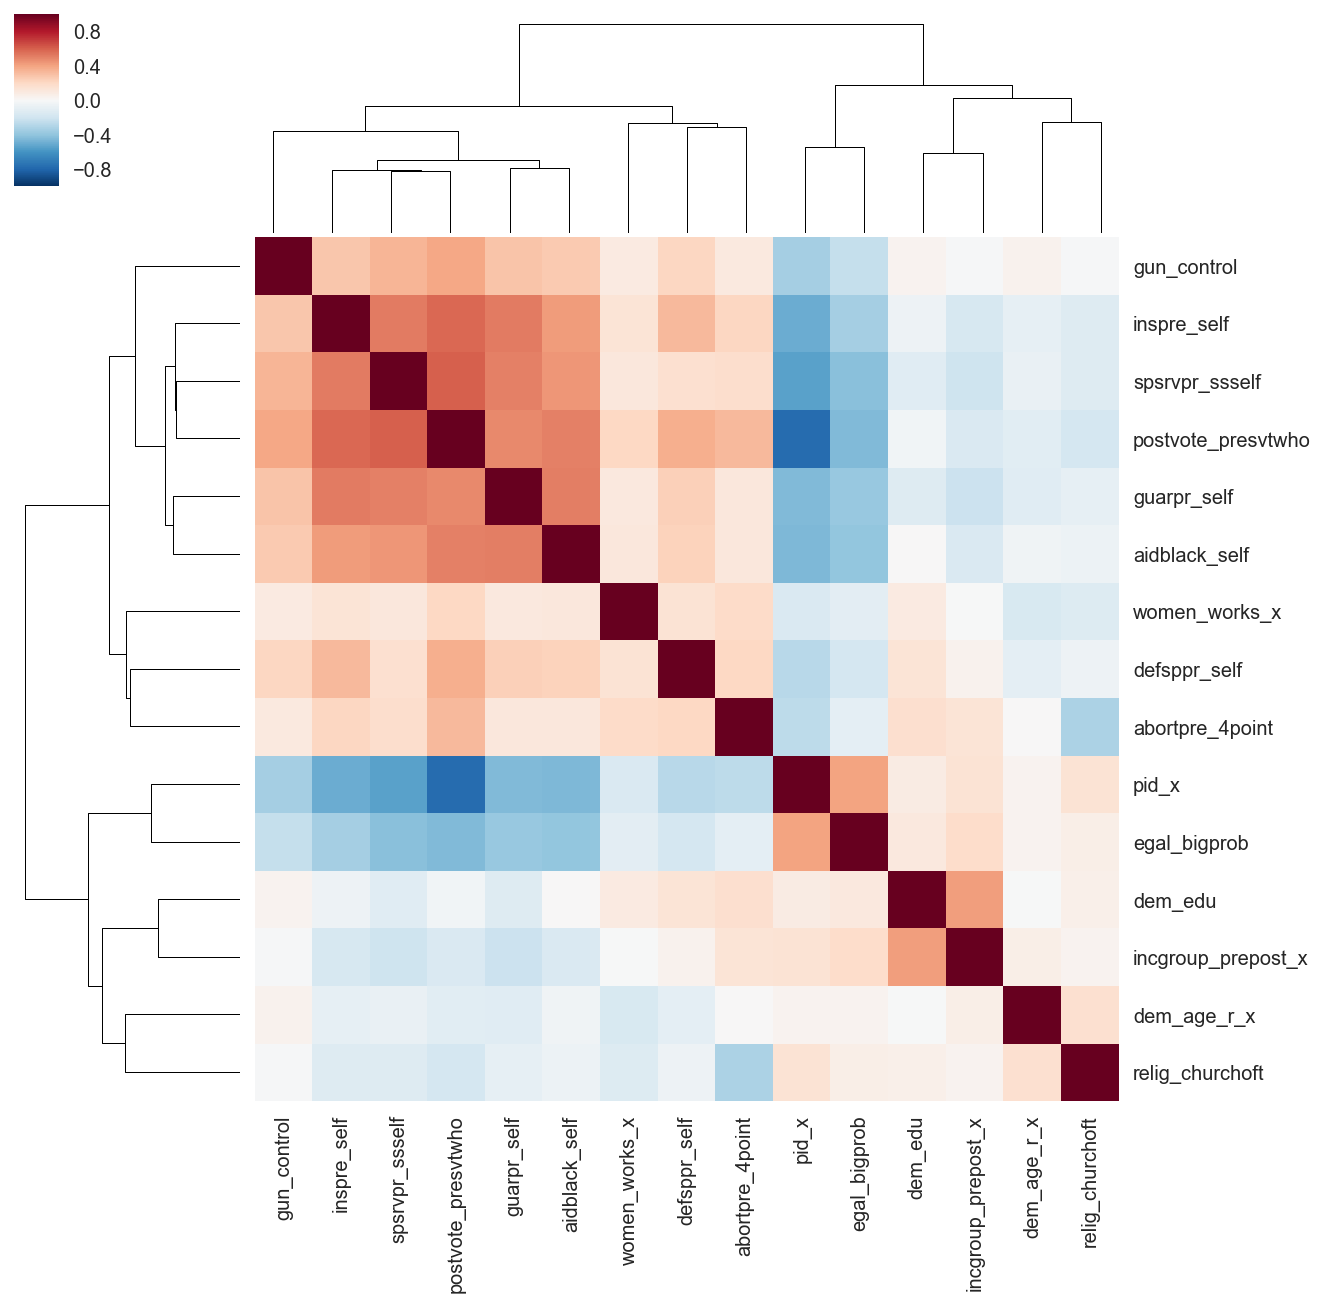

In [14]:
cg = sns.clustermap(correlations, square=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(),
        rotation=0);  # Fix rotation of y-labels.

## Principal component analysis

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler

imp = Imputer(strategy='mean')
scl = StandardScaler()
pca = PCA()
pipeline = Pipeline([
        ('imp', imp),
        ('scl', scl),
        ('pca', pca),
    ])
scaler_pipeline = Pipeline([
        ('imp', imp),
        ('scl', scl),
    ])
data_pca = pipeline.fit_transform(df)
_scaled = scaler_pipeline.transform(df)

### Explained variance

How much of the variance in the data is explained by each successive component?

In [16]:
plot_explained_variance(pca)

In [17]:
pca.explained_variance_

array([ 4.14399924,  1.66132878,  1.23819133,  1.0444993 ,  0.87204941,
        0.82612773,  0.77592626,  0.72242237,  0.69773536,  0.60702242,
        0.58876228,  0.56584688,  0.48407751,  0.44906816,  0.32294297])

In [22]:
pd.DataFrame(_scaled, columns=df.columns).head()

,dem_age_r_x,dem_edu,relig_churchoft,pid_x,incgroup_prepost_x,defsppr_self,spsrvpr_ssself,inspre_self,guarpr_self,gun_control,aidblack_self,abortpre_4point,women_works_x,egal_bigprob,postvote_presvtwho
0,2.184500,-3.104226,-1.753506e+00,-1.198772,-1.405242,6.183912e-16,7.234006e-01,-0.527535,0.000000,0.945932,2.234396e+00,-0.878801,3.225399e-16,-3.619528e-16,0.000000
1,1.766215,-2.697162,-4.657797e-16,-1.198772,-0.786066,2.152230e+00,7.234006e-01,1.579138,1.795007,0.945932,-5.244668e-16,0.042980,3.225399e-16,-1.434592e+00,1.030681
2,1.347929,-0.254780,1.393022e+00,-1.198772,-1.281407,6.183912e-16,1.371272e+00,1.052470,1.229998,-0.734996,-5.244668e-16,0.964760,-1.411183e+00,-6.195470e-01,1.030681
3,0.272338,-0.254780,-2.802349e+00,-1.198772,-1.405242,6.183912e-16,-2.877126e-16,1.579138,0.099981,-0.734996,2.234396e+00,0.964760,7.677028e-01,-1.434592e+00,1.030681
4,-0.863009,-0.661844,-4.657797e-16,-0.248978,-0.043055,6.349039e-02,7.234006e-01,1.579138,0.664990,-0.734996,2.234396e+00,0.964760,7.677028e-01,1.954982e-01,1.030681


### Biplot

A scatterplot projected onto the first two principal components.

In [31]:
plt.figure()
data_scaled = pd.DataFrame(_scaled, columns=df.columns)
triplot(pca, data_scaled, title='ANES 2012 Biplot', color=data_scaled.pid_x)

Sure, all of the original axes are negative in the first component. That's okay! To quote Dr. Eric Larson: 
> Because all the data is somewhat correlated, giving a mostly unidimensional representation. Positive/negative isn't so important because eigenvectors could theoretically start anywhere--but traditionally we use the origin.

**Update:** The demographic factor of education level has a different sign from the others.

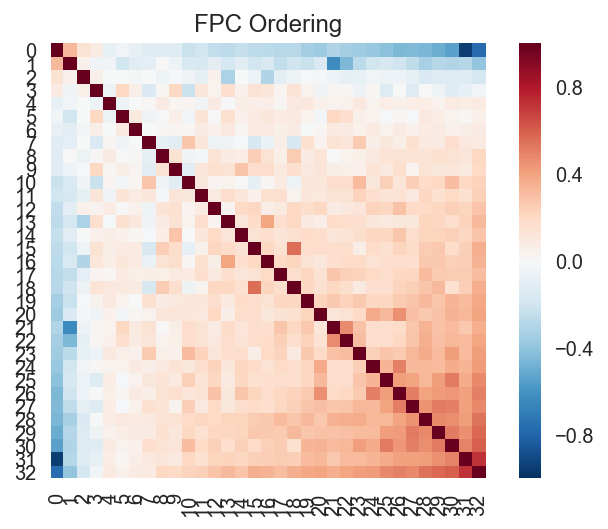

In [11]:
def fpc_ordered(corr):
    """Reorder correlation matrix based on first principal component (FPC)."""
    ew, ev = np.linalg.eig(corr)
    idx = np.argsort(ew)[::-1]  # Reordering index of eigenvalues
    ew, ev = ew[idx], ev[:, idx]
    e1 = ev[:, 0]
    order = np.argsort(e1)
    try:
        return corr.values[:, order][order]
    except AttributeError:
        return corr[:, order][order]
sns.heatmap(fpc_ordered(correlations),
           square=True)
plt.title("FPC Ordering");

### Norris ordering

Arrange correlation matrix by sum of principal components (left singular vectors), weighted by singular values.

In [12]:
U, S, V = PCA()._fit(X=_scaled)
np.allclose(U @ np.diag(S) @ V, _scaled)

True

We see something important here: normally, the singular value decomposition is $\mathbf{A} = \mathbf{U\Sigma V^T}$ where the columns of $\mathbf{V}$ are the left singular vectors. Here, we see that $\mathbf{A} = \mathbf{U\Sigma V}$. Consequently, the rows of $\mathbf{V}$ are the left singular vectors.

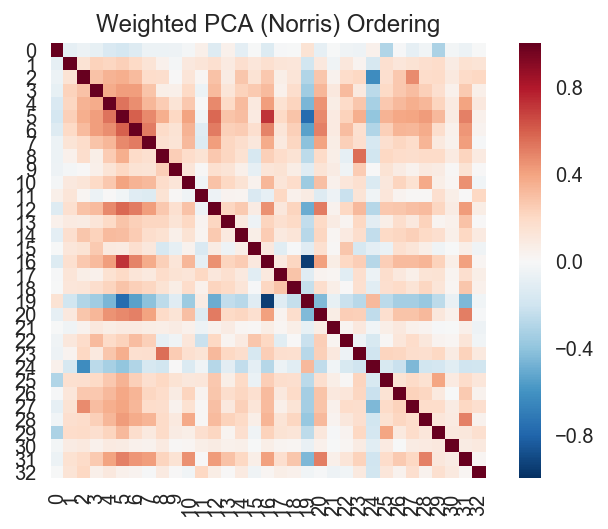

In [15]:
weights = np.abs(S @ V)  # Total weights of each scaled component
norris_ordering = np.argsort(weights)[::-1]
sns.heatmap(correlations.values[:, norris_ordering][norris_ordering],
           square=True)
plt.title("Weighted PCA (Norris) Ordering");

In [16]:
import rpy2.ipython

In [17]:
scaled = pd.DataFrame(_scaled, columns=df.columns)

In [18]:
%load_ext rpy2.ipython

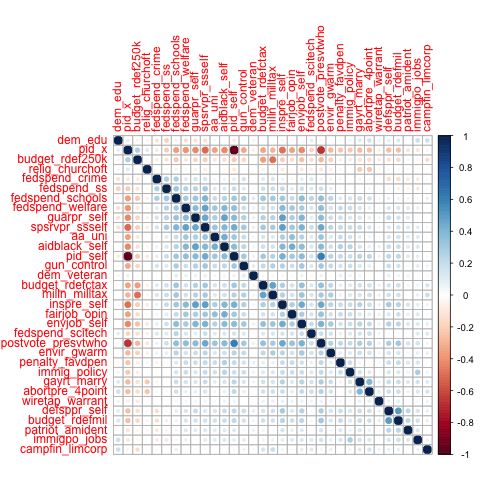

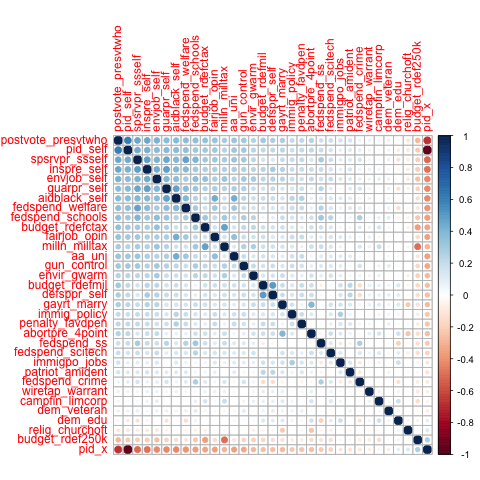

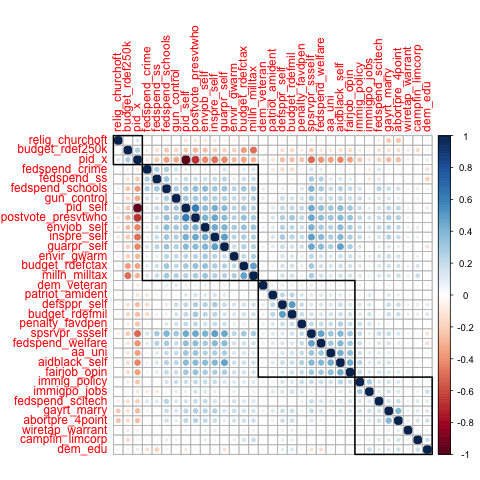

In [19]:
%%R -i scaled
library(corrplot)
M <- cor(scaled)
(order.AOE <- corrMatOrder(M, order = "AOE"))
(order.FPC <- corrMatOrder(M, order = "FPC"))
M.AOE <- M[order.AOE,order.AOE]
M.FPC <- M[order.FPC,order.FPC]
corrplot(M.AOE)
corrplot(M.FPC)
corrplot(M, order = "hclust", addrect = 4)

## Grouping by largest corresponding principal component

PCA transforms data of shape `(n_samples, n_features)` into `(n_samples, n_components)` where `n_components ≤ n_features`. The inverse transform, then, converts data of shape `(m, n_components)` to `(m, n_features)`. We want to determine the weights of each feature in the original space. Transforming the identity matrix into the *singular space* would give us the principal components; conversely, transforming the identity matrix *from* the singular space gives us the weights of the basis vectors in each principal component.

In [20]:
N_COMPONENTS = 3
pca_inverse = np.abs(pca.inverse_transform(np.eye(pca.n_components_)))
most_contributing_component = np.argmax(pca_inverse[:,:N_COMPONENTS], axis=1)
print(np.bincount(most_contributing_component))

[10 11 12]


In [21]:
ordering = np.argsort(most_contributing_component)
print(np.sort(most_contributing_component))

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]


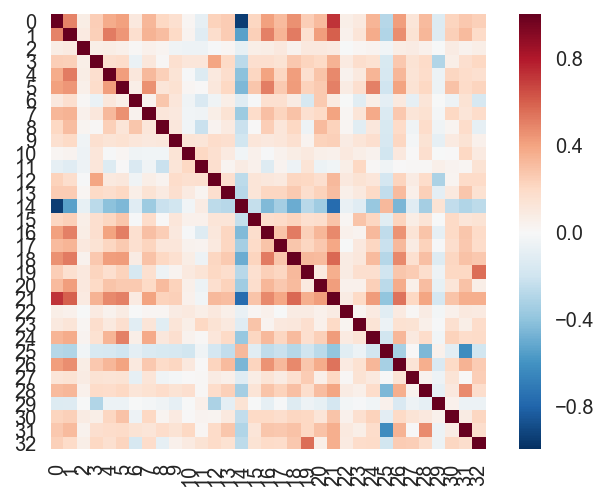

In [23]:
sns.heatmap(correlations.values[:, ordering][ordering],
           square=True);